In [1]:
# necessary library
import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 

**get the path**

In [2]:
path ='/kaggle/input/challenges-in-representation-learning-facial-expression-recognition-challenge/icml_face_data.csv'

In [3]:
# Load the data
data = pd.read_csv(path)

In [4]:
data = data.rename(columns = {" pixels": "pixels", " Usage": "usage"})

**Extract training,validation and testing data from data**

In [5]:
train_data = data.loc[data['usage'] == 'Training'].drop('usage', axis = 1).reset_index(drop = True)
val_data = data.loc[data['usage'] == 'PublicTest'].drop('usage', axis = 1).reset_index(drop = True)
test_data = data.loc[data['usage'] == 'PrivateTest'].drop('usage', axis = 1).reset_index(drop = True)


In [6]:
#Convert pixel strings to Numpy arrays
train_images=np.array([np.fromstring(pixel,dtype=int,sep=' ') for pixel in train_data['pixels']])
val_images=np.array([np.fromstring(pixel,dtype=int,sep=' ') for pixel in val_data['pixels']])
test_images=np.array([np.fromstring(pixel,dtype=int,sep=' ') for pixel in test_data['pixels']])

**Reshape**

In [7]:
#Reshape to (48,48,1)
train_images=train_images.reshape(-1,48,48,1)
val_images=val_images.reshape(-1,48,48,1)
test_images=test_images.reshape(-1,48,48,1)

In [8]:
print(train_images.shape)
print(val_images.shape)
print(test_images.shape)

(28709, 48, 48, 1)
(3589, 48, 48, 1)
(3589, 48, 48, 1)


**One_hot_encodings**

In [9]:
from keras.utils import to_categorical

train_labels = to_categorical(train_data['emotion'], num_classes=7)
val_labels = to_categorical(val_data['emotion'], num_classes=7)
test_labels = to_categorical(test_data['emotion'], num_classes=7)

In [10]:
# Concatenate images and labels along the first axis (axis=0)
train_images = np.concatenate((train_images, val_images), axis=0)
train_labels = np.concatenate((train_labels, val_labels), axis=0)

In [11]:
print(train_images.shape)
print(train_labels.shape)

(32298, 48, 48, 1)
(32298, 7)


**Data Augmentation**

it does not work well with this data set

In [12]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# # Define the augmentation generator
# datagen = ImageDataGenerator(
#     rotation_range=30,  # Rotate images by up to 30 degrees
#     zoom_range=0.2,  # Zoom in/out by up to 20%
#     width_shift_range=0.2,  # Shift horizontally by up to 20%
#     height_shift_range=0.2,  # Shift vertically by up to 20%
#     horizontal_flip=True,  # Flip images horizontally
#     fill_mode='nearest'  # Fill missing pixels with nearest values
# )

# # Assuming train_images is your preprocessed training data
# datagen.fit(train_images)

**Build a Model**

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam


In [14]:
# Add some  Regularization  to avoid overfiting
model = Sequential([
    Conv2D(32, (3, 3),kernel_regularizer=l2(0.001), activation='relu', input_shape=(48, 48, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3) ,kernel_regularizer=l2(0.001),activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(124, (3, 3) ,kernel_regularizer=l2(0.001),activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3) ,kernel_regularizer=l2(0.001), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dense(128, kernel_regularizer=l2(0.001),activation='relu'),
    Dropout(0.5),
    Dense(128,kernel_regularizer=l2(0.001),activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')
])
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 46, 46, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 23, 23, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 21, 21, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 10, 10, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 124)           │          71,548 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 124)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 2, 2, 256)           │         285,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 1, 1, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 426,627 (1.63 MB)

 Trainable params: 426,627 (1.63 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model without validation
history = model.fit(
    x=train_images, 
    y=train_labels,
    batch_size=32,
    epochs=80
)

Epoch 1/80
1010/1010 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.1812 - loss: 3.1677
Epoch 2/80
1010/1010 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.2310 - loss: 2.2820
Epoch 3/80
1010/1010 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.2444 - loss: 2.1846
Epoch 4/80
1010/1010 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.2878 - loss: 2.0637
Epoch 5/80
1010/1010 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.3478 - loss: 1.9098
Epoch 6/80
1010/1010 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.3944 - loss: 1.7831
Epoch 7/80
1010/1010 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4458 - loss: 1.6679
Epoch 8/80
1010/1010 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4813 - loss: 1.5637
Epoch 9/80
1010/1010 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5055 - loss: 1.4932
Epoch 10/80
1010/1010 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5430 - loss: 1.4043
Epoch 11/80
1010/1010 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5640 - loss: 1.3475
Epoch 12/80
1010/1010 ━━━━━━━

In [16]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_images,test_labels)
print(f"Test Accuracy: {test_accuracy:.4f}")

113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5658 - loss: 2.8441
Test Accuracy: 0.5651


**# Plot training and validation loss**

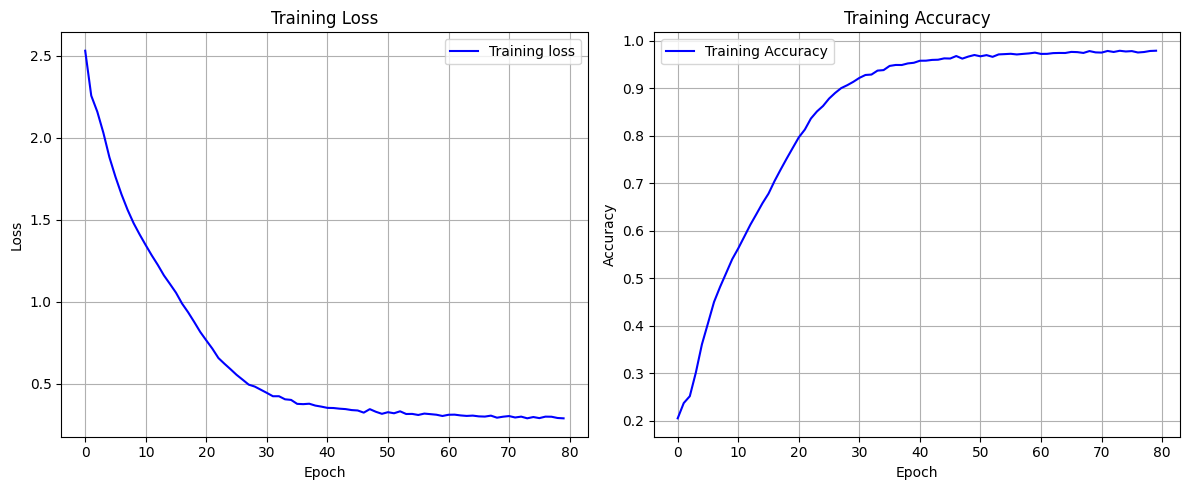

In [17]:
plt.figure(figsize=(12, 5))

# Loss curve
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Training loss' ,color='blue',linestyle='-')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)


## Accuracy curve
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Training Accuracy' ,color='blue',linestyle='-')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# we need to adjust spacing between subplots
plt.tight_layout()
plt.show()